In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

In [3]:
session = requests.Session()
retry = Retry(connect=3, backoff_factor=0.5)
adapter = HTTPAdapter(max_retries=retry)
session.mount('http://', adapter)
session.mount('https://', adapter)

In [4]:
import json
import numpy as np
from pandas import json_normalize

In [5]:
import nltk
import spacy
from spacy.matcher import PhraseMatcher
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline
from textblob import Word

In [6]:
import time

In [6]:
#nltk.download('wordnet')

In [7]:
#pip install -U textblob

In [8]:
#pip install -U scikit-learn

In [9]:
#pip install nltk

In [10]:
#pip install spacy

In [6]:
url = "https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?https://www.linkedin.com/jobs/search/?currentJobId=3572903359&f_I=96%2C4&f_TPR=r2592000&geoId=101174742&location=Canada&refresh=true&sortBy=R&start={}"

In [7]:
num_of_loops = 20

In [ ]:
jobID_list = []
for i in range(num_of_loops):
    r = requests.get(url.format(i*25))
    print(i)
    soup = BeautifulSoup(r.content,'html.parser')
    alljobs_on_this_page=soup.find_all("li")
    for x in range(0,len(alljobs_on_this_page)):
        jobID = alljobs_on_this_page[x].find("div",{"class":"base-card"}).get('data-entity-urn').split(":")[3]
        jobID_list.append(jobID)

In [ ]:
job_url='https://www.linkedin.com/jobs-guest/jobs/api/jobPosting/{}'

details = {}

job_detail = []

for job in range(0,len(jobID_list)):

    r_job = requests.get(job_url.format(jobID_list[job]))
    soup = BeautifulSoup(r_job.content,'html.parser')
    
    print(job)

    try:
        details["Company"] = soup.find("div",{"class":"top-card-layout__card"}).find("a").find("img").get('alt')
    except:
        details["Company"] = None

    try:
        details["Job_Title"] = soup.find("div",{"class":"top-card-layout__entity-info"}).find("a").text.strip()
    except:
        details["Job_Title"] = None

    try:
        details["Level"] = soup.find("ul",{"class":"description__job-criteria-list"}).find("li").text.replace("Seniority level","").strip()
    except:
        details["Level"] = None
        
    try:
        details["Location"] = soup.find("span",{"class":"topcard__flavor topcard__flavor--bullet"}).text.strip()
    except:
        details["Location"] = None
        
    try:
        details["Description"] = soup.find("div",{"class":"show-more-less-html__markup show-more-less-html__markup--clamp-after-5"}).text.strip()
    except:
        details["Description"] = None


    job_detail.append(details)
    
    details={}


In [10]:
job_data_2 = pd.DataFrame(job_detail)

In [11]:
job_data_2.head(5)

,Company,Job_Title,Level,Location,Description
0,Tech Foorti,Virtual Office Assistant / Entry level (Remote),Entry level,"Northeast Calgary, Alberta, Canada",We are seeking a proactive and detail-oriented...
1,Valsoft Corporation,"Investment Associate, Private Equity",Entry level,"Montréal-Ouest, Quebec, Canada",Valsoft Corporation is currently looking for a...
2,Tech Foorti,Human Resources Assistant / Full time (Remote),Entry level,"Edmonton, Alberta, Canada",We are seeking a highly motivated and detail-o...
3,Tech Foorti,Administrative Executive Assistant / Full time...,Mid-Senior level,"Northeast Calgary, Alberta, Canada",Our organization is seeking a motivated and de...
4,HP,Business Analyst - Graduate,Entry level,"Plummer Additional, Ontario, Canada",This Business analyst will be part of EMEA Ind...


In [12]:
job_data_2.tail(5)

,Company,Job_Title,Level,Location,Description
495,Procom,Scrum Master,Mid-Senior level,"Edmonton, Alberta, Canada","On behalf of our client, Procom is seeking a S..."
496,Zortech Solutions,Product Owner,Director,"Mississauga, Ontario, Canada","Mississauga, CanadaPermanent (Full-time)JD for..."
497,Amaris Consulting,Pharmaceutical - Data Scientist,Entry level,"Toronto, Ontario, Canada",Who are we?Amaris Consulting is an independent...
498,Zortech Solutions,Mobile QA Test Analyst,Entry level,"Calgary, Alberta, Canada",Role: Mobile QA Test Analyst| Job Location: Ca...
499,GIRO,Security Expert Analyst,Mid-Senior level,"Montréal-Ouest, Quebec, Canada",Company DescriptionOur specialty is to optimiz...


In [13]:
job_data_2.apply(lambda x: sum(x.isnull()))

Company        0
Job_Title      0
Level          0
Location       0
Description    0
dtype: int64

In [14]:
job_data_2.shape

(500, 5)

In [15]:
#job_data_2.to_csv("DataJob_2.csv", sep='\t', encoding='utf-8')

In [31]:
#job_data.to_csv("DataJob.csv", sep='\t', encoding='utf-8')

In [11]:
#job_data = pd.read_csv("DataJob.csv", sep='\t')

In [15]:
## Lower case
job_data_2['Description']  = job_data_2['Description'].apply(lambda x: " ".join(x.lower()for x in x.split()))
# remove tabulation and punctuation
job_data_2['Description'] = job_data_2['Description'].str.replace('[^\w\s]',' ')
## digits
job_data_2['Description'] = job_data_2['Description'].str.replace('\d+', '')

#remove stop words
stop = stopwords.words('english')
job_data_2['Description'] = job_data_2['Description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

## lemmatization
job_data_2['Description'] = job_data_2['Description'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

C:\Users\nsigh\AppData\Local\Temp\ipykernel_8044\151618536.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  job_data_2['Description'] = job_data_2['Description'].str.replace('[^\w\s]',' ')
C:\Users\nsigh\AppData\Local\Temp\ipykernel_8044\151618536.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  job_data_2['Description'] = job_data_2['Description'].str.replace('\d+', '')


In [49]:
auth_endpoint = "https://auth.emsicloud.com/connect/token" # auth endpoint

client_id = "tzrymwzgtqci6dj6" # replace 'your_client_id' with your client id from your api invite email
client_secret = "9s07z0Sc" # replace 'your_client_secret' with your client secret from your api invite email
scope = "emsi_open" # ok to leave as is, this is the scope we will used

payload = "client_id=" + client_id + "&client_secret=" + client_secret + "&grant_type=client_credentials&scope=" + scope # set credentials and scope
headers = {'content-type': 'application/x-www-form-urlencoded'} # headers for the response
access_token = json.loads((requests.request("POST", auth_endpoint, data=payload, headers=headers)).text)['access_token'] # grabs request's text and loads as JSON, then pulls the access token from that

In [24]:
all_skills_endpoint = "https://emsiservices.com/skills/versions/latest/skills" # List of all skills endpoint
auth = "Authorization: Bearer " + access_token # Auth string including access token from above
headers = {'authorization': auth} # headers
querystring = {"typeIds":"ST1,ST2","fields":"id,name,type"}
response = requests.request("GET", all_skills_endpoint, headers=headers, params=querystring) # response
response = response.json()['data'] # the data
    
all_skills_df = pd.DataFrame(json_normalize(response)); # Where response is a JSON object drilled down to the level of 'data' key

In [25]:
all_skills_df.head()

,id,name,type.id,type.name
0,KS126XS6CQCFGC3NG79X,.NET Assemblies,ST1,Specialized Skill
1,ES50D03AC9CFC1A0BC93,.NET Development,ST1,Specialized Skill
2,KS1200B62W5ZF38RJ7TD,.NET Framework,ST1,Specialized Skill
3,KS126XW78QJCF4TRV2X7,.NET Framework 1,ST1,Specialized Skill
4,KS126XY68BNKXSBSLPYS,.NET Framework 3,ST1,Specialized Skill


In [26]:
all_skills_df.apply(lambda x: sum(x.isnull()))

id           0
name         0
type.id      0
type.name    0
dtype: int64

<Axes: >

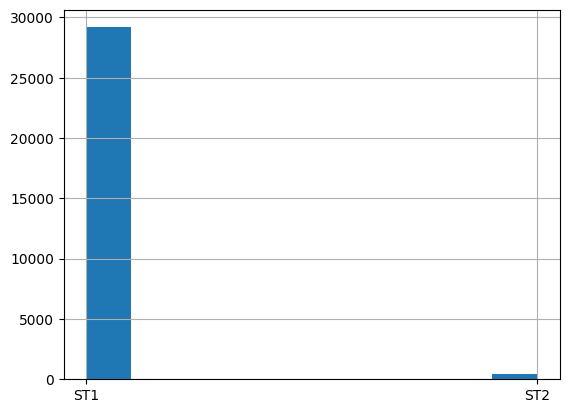

In [27]:
all_skills_df["type.id"].hist()

In [77]:
# Extract skills from a document
def extract_skills_from_document(text, confidence_interval):
    skills_from_doc_endpoint = "https://emsiservices.com/skills/versions/latest/extract"
    payload = "{ \"text\": \"... " + text + " ...\", \"confidenceThreshold\": " + confidence_interval + " }"

    headers = {
        'authorization': "Bearer " + access_token,
        'content-type': "application/json"
      }

    response = requests.request("POST", skills_from_doc_endpoint, data=payload.encode('utf-8'), headers=headers)

    skills_found_in_document_df = pd.DataFrame(json_normalize(response.json()['data']));# Where response is a JSON object drilled down to the level of 'data' key
    
    skills = ', '.join(skills_found_in_document_df['skill.name'])
    
    return skills

In [90]:
job_data_2.head()

,Company,Job_Title,Level,Location,Description
0,Tech Foorti,Virtual Office Assistant / Entry level (Remote),Entry level,"Northeast Calgary, Alberta, Canada",seeking proactive detail oriented individual j...
1,Valsoft Corporation,"Investment Associate, Private Equity",Entry level,"Montréal-Ouest, Quebec, Canada",valsoft corporation currently looking investme...
2,Tech Foorti,Human Resources Assistant / Full time (Remote),Entry level,"Edmonton, Alberta, Canada",seeking highly motivated detail oriented human...
3,Tech Foorti,Administrative Executive Assistant / Full time...,Mid-Senior level,"Northeast Calgary, Alberta, Canada",organization seeking motivated detail oriented...
4,HP,Business Analyst - Graduate,Entry level,"Plummer Additional, Ontario, Canada",business analyst part emea industrial supply t...


In [89]:
job_data_2 = job_data_2.drop(['Job_Skills'], axis=1)
job_data_2.drop_duplicates(inplace = True)

In [85]:
job_data_2.shape[0]

415

In [ ]:
skills

In [63]:
skills_pd = pd.DataFrame(columns=['skill.name','skill.type.name'])

In [117]:
text = ', '.join(job_data_2['Description'][405:415])
confidence_interval = "0.7"

In [118]:
skills_from_doc_endpoint = "https://emsiservices.com/skills/versions/latest/extract"
payload = "{ \"text\": \"... " + text + " ...\", \"confidenceThreshold\": " + confidence_interval + " }"

headers = {
    'authorization': "Bearer " + access_token,
    'content-type': "application/json"
    }

response = requests.request("POST", skills_from_doc_endpoint, data=payload.encode('utf-8'), headers=headers)

skills_found_in_document_df = pd.DataFrame(json_normalize(response.json()['data']));# Where response is a JSON object drilled down to the level of 'data' key
    
skills_pd = skills_pd.append(skills_found_in_document_df[["skill.name","skill.type.name"]],ignore_index = True)
    
#skills += ', '.join(skills_found_in_document_df['skill.name'])

C:\Users\nsigh\AppData\Local\Temp\ipykernel_19716\2438235273.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  skills_pd = skills_pd.append(skills_found_in_document_df[["skill.name","skill.type.name"]],ignore_index = True)


In [64]:
#skills_pd = skills_pd.append(skills_found_in_document_df[["skill.name","skill.type.name"]],ignore_index = True)

C:\Users\nsigh\AppData\Local\Temp\ipykernel_19716\1644623930.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  skills_pd = skills_pd.append(skills_found_in_document_df[["skill.name","skill.type.name"]],ignore_index = True)


In [119]:
skills_pd.shape

(5367, 2)

In [73]:
response.json()

{'errors': [{'detail': 'Request size too large',
   'status': 413,
   'title': 'Payload Too Large'}]}

In [36]:
for i in range(0,job_data_2.shape[0]/20):
    i = 0
    n = 20
    text = ', '.join(job_data_2['Description'][i:n])
    confidence_interval = 0.7

In [51]:
#pip install aspose-words

^C
Note: you may need to restart the kernel to use updated packages.


In [37]:
with open("Text3.txt", "w", encoding="utf-8") as f:
    f.write(skills)
    f.close()

In [7]:
job_data_2 = pd.read_csv("Job_data.csv", sep='\t')

In [ ]:
skills

In [39]:
skills_list = list(skills.split(", "))

In [43]:
skills_df = pd.DataFrame({'skills':skills_list})

In [120]:
skills_pd.to_csv("List_Skills.csv", sep='\t', encoding='utf-8')

In [60]:
import aspose.words as aw

#292 pages/docs
#Each page is about 4KB
#I need to narrow it down to about 30-40 docs
#And about 40-50KB

doc = aw.Document("Text2.txt")
    
for page in range(0, 40):
    n = 10
    i = 0
    extractedPage = doc.extract_pages(i, n)
    extractedPage.save(f"Output_{page + 1}.txt")
    n += 10
    i += 10

In [19]:
# Looking up the ID of a skill based on the name, or whether it contains something
# Could be useful in coming up with a search function for the end user

def find_id_by_skill_name(name_substring):
    all_skills_df = extract_skills_list() # pull all skills into a DF

    return all_skills_df[all_skills_df['name'].str.contains(name_substring)] # Filter that DF by substring

In [10]:
# Skills IDs to find related skills to:
# Python (Programming Language): KS125LS6N7WP4S6SFTCK
# Transact-SQL: KS441H25X1LXDV8C9R0W


url = "https://emsiservices.com/skills/versions/latest/related"

payload = "{ \"ids\": [ \"KS125LS6N7WP4S6SFTCK\", \"KS441H25X1LXDV8C9R0W\" ] }"
headers = {
    'authorization': "Bearer " + access_token,
    'content-type': "application/json"
    }

response = session.request("POST", url, data=payload, headers=headers)
related_skills_df = pd.DataFrame(json_normalize(response.json()['data']))

related_skills_df

,id,infoUrl,name,type.id,type.name
0,KS1200364C9C1LK3V5Q1,https://skills.emsidata.com/skills/KS1200364C9...,C (Programming Language),ST1,Specialized Skill
1,KS1219N6Z3XQ19V0HSKR,https://skills.emsidata.com/skills/KS1219N6Z3X...,C# (Programming Language),ST1,Specialized Skill
2,KS1219W70LY1GXZDSKW5,https://skills.emsidata.com/skills/KS1219W70LY...,C++ (Programming Language),ST1,Specialized Skill
3,KS7LO8P3MXB93R3C9RWL,https://skills.emsidata.com/skills/KS7LO8P3MXB...,Data Science,ST1,Specialized Skill
4,KS122VT6S2JJ5C5D80NF,https://skills.emsidata.com/skills/KS122VT6S2J...,Linux,ST1,Specialized Skill
5,KS1261Z68KSKR1X31KS3,https://skills.emsidata.com/skills/KS1261Z68KS...,Machine Learning,ST1,Specialized Skill
6,KS123GK6Z30G7QTFCY4N,https://skills.emsidata.com/skills/KS123GK6Z30...,Perl (Programming Language),ST1,Specialized Skill
7,KS124DQ6JX0NX9DBFDM8,https://skills.emsidata.com/skills/KS124DQ6JX0...,R (Programming Language),ST1,Specialized Skill
8,KS440W865GC4VRBW6LJP,https://skills.emsidata.com/skills/KS440W865GC...,SQL (Programming Language),ST1,Specialized Skill
9,KS7G0C36YW29VS8KPC05,https://skills.emsidata.com/skills/KS7G0C36YW2...,Scripting,ST1,Specialized Skill
